<a href="https://colab.research.google.com/github/EpicMike87/AIProject/blob/main/bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [301]:
!pip install gym-anytrading gym sb3_contrib finta

# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gym_anytrading.envs import StocksEnv
from finta import TA

In [302]:
macd_result = TA.MACD(df, 12, 26)
df['MACD'] = macd_result['MACD']
df['MACD_SIGNAL'] = macd_result['SIGNAL']
df['MOM'] = TA.MOM(df, 10)
df.fillna(0, inplace=True)

In [303]:
df = df.drop(df.index[:100])
df.head(15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Volume,High,Low,Open,Close,MACD,MACD_SIGNAL,MOM
Date,,,,,,,,
2023-11-15 18:30:00,490816.0,450.019989,449.592194,449.734985,450.000000,-0.170777,-0.181059,0.041412
2023-11-15 18:35:00,465766.0,450.059998,449.850006,449.989990,449.959991,-0.137176,-0.172283,-0.145020
2023-11-15 18:40:00,501155.0,450.190002,449.945007,449.950012,450.070007,-0.100514,-0.157929,0.090118
2023-11-15 18:45:00,251484.0,450.154999,449.970001,450.089996,450.089996,-0.069051,-0.140153,0.320007
2023-11-15 18:50:00,474674.0,450.309998,450.049988,450.160004,450.170013,-0.037233,-0.119569,0.620026
2023-11-15 18:55:00,990657.0,450.260010,450.070007,450.170013,450.225006,-0.007494,-0.097154,1.115021
2023-11-15 19:00:00,836886.0,450.475006,450.204987,450.230011,450.359985,0.026657,-0.072392,1.349976
2023-11-15 19:05:00,475565.0,450.470001,450.279999,450.359985,450.339996,0.051514,-0.047611,1.148010
2023-11-15 19:10:00,559296.0,450.434998,450.279999,450.350006,450.295013,0.066815,-0.024726,0.664917


In [304]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','MACD', 'MACD_SIGNAL', 'MOM']].to_numpy()[start:end]
    return prices, signal_features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [305]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df, window_size=25, frame_bound=(50,1000))

In [306]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Volume,High,Low,Open,Close,MACD,MACD_SIGNAL,MOM
Date,,,,,,,,
2023-11-15 18:30:00,490816.0,450.019989,449.592194,449.734985,450.000000,-0.170777,-0.181059,0.041412
2023-11-15 18:35:00,465766.0,450.059998,449.850006,449.989990,449.959991,-0.137176,-0.172283,-0.145020
2023-11-15 18:40:00,501155.0,450.190002,449.945007,449.950012,450.070007,-0.100514,-0.157929,0.090118
2023-11-15 18:45:00,251484.0,450.154999,449.970001,450.089996,450.089996,-0.069051,-0.140153,0.320007
2023-11-15 18:50:00,474674.0,450.309998,450.049988,450.160004,450.170013,-0.037233,-0.119569,0.620026


In [307]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [308]:
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)

Using cpu device
----------------------------
| time/              |     |
|    fps             | 166 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0012716455 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | -2.77        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.034        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00506     |
|    value_loss           | 0.145        |
------------------------------------------
------

KeyboardInterrupt: 

In [309]:
env = MyCustomEnv(df=df, window_size=25, frame_bound=(2500,3000))
obs = env.reset()
obs = obs[0]
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    done = truncated or terminated

    print("info", info)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}
info {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Long: 1>}
info {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Long: 1>}
info {'total_reward': 0.1450195311999778, 'total_profit': 0.9853542273885633, 'position': <Positions.Short: 0>}
info {'total_reward': 0.1450195311999778, 'total_profit': 0.9853542273885633, 'position': <Positions.Short: 0>}
info {'total_reward': 0.1450195311999778, 'total_profit': 0.9853542273885633, 'position': <Positions.Short: 0>}
info {'total_reward': 0.1450195311999778, 'total_profit': 0.9853542273885633, 'position': <Positions.Short: 0>}
info {'total_reward': 0.1450195311999778, 'total_profit': 0.9853542273885633, 'position': <Positions.Long: 1>}
info {'total_reward': 0.20501708979998057, 'total_profit': 0.97074713609945, 'position': <Positions.Short: 0>}
info {'total_reward': 0.20501708979998057, 'total_profit': 0.97074713609945, 'position

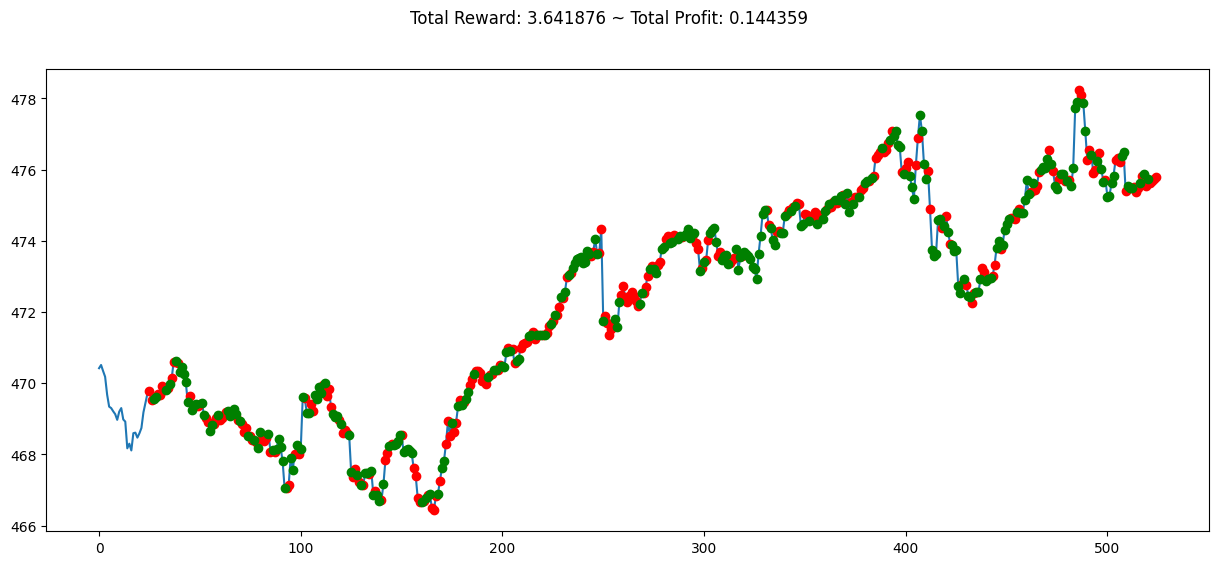

In [310]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()